---
---
## Copyright © 2022 ~ MIT License
> S. Weggeman, University of Groningen
---
---

This code is part of my Master's Thesis:

"*The difference between acted and spontaneous laughter and its relevance for laughter synthesis; A case study on LaughNet.*" (2022/2023)

In [ ]:
#install required libraries and packages
!pip install praat-parselmouth
!pip install factor-analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 41.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 812.8 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 31.3 MB/s eta 0:00:00
  Created wheel for factor-analyzer: filename=factor_analyzer-0.4.1-py2.py3-none-any.whl size=42014 sha256=04c0f2a73fbc9cb4de4e24b5a06a2c81bc79e55fc4d084df6646928f5f452b96
  Stored in 

In [ ]:
#import required libraries and packages
import pandas as pd
import os
import librosa
import parselmouth
import numpy as np
from google.colab import files
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import math
import regex as re
from typing import List
from sklearn.metrics import classification_report, confusion_matrix
from factor_analyzer.factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity

In [ ]:
#functional aesthetics
pd.set_option('display.max_rows', None)
sns.set_theme()

---
### Data preparation
---

In [ ]:
def extract_params(data) -> pd.core.frame.DataFrame:
  '''This function takes the data, preprocesses it, and extracts the duration,
  the percentage of unvoiced segments, the mean-, minimum-, maximum-, and
  variability of the fundamental frequency, and the intensity of each datafile.
  It then stores these parameters together in a pandas DataFrame as one
  datapoint. In the end it returns the entire DataFrame of all datapoints.'''

  #create a dataframe with columns for each parameter
  cols = ["Duration", "Percentage unvoiced segments", "F0 mean", "F0 minimum", "F0 maximum", "F0 variability", "Intensity", "Label", "Filename"]
  df = pd.DataFrame(columns=cols)

  #loop over each file in the data
  for f in data:
    #load file
    fp = os.path.join("/content/", f)
    audio, sr = librosa.load(fp)

    #determine and set the label (acted: 0 or spontaneous: 1)
    is_spontaneous = f[0].isdigit()
    label = int(is_spontaneous)

    #transform audio into a Sound object for Parselmouth to work with
    snd = parselmouth.Sound(audio, sr)

    #cut leading and trailing silences
    trimmed_snd = trim(audio, sr, snd)

    #transform trimmed sound to Pitch object for extraction of pitch related features
    pitch = parselmouth.Sound.to_pitch(trimmed_snd, 0.08, 75.0, 1000.0)

    #extract features
    dur = duration(trimmed_snd)
    per_u_s = per_unvoiced_seg(pitch)
    mean, min, max ,var = f0_stats(pitch)
    inty = intense(trimmed_snd)

    #store features as one datapoint
    temp_store = []
    temp_store.append(dur)
    temp_store.append(per_u_s)
    temp_store.append(mean)
    temp_store.append(min)
    temp_store.append(max)
    temp_store.append(var)
    temp_store.append(inty)
    temp_store.append(label)
    temp_store.append(f)
    df = pd.concat([df, pd.Series(temp_store, index=cols).to_frame().T], ignore_index=True)

  #drop rows with NaN values
  if df.isna().any(axis=1).sum()>0:
    nans = [i for i, j in enumerate(df.isna().any(axis=1)[:]) if j]
    for k in nans:
      fn_rem = df.query(str(k))["Filename"]
      print(f"{fn_rem} has outlying parameters and hence has been removed.")
    df = df.drop(nans)

  return df

In [ ]:
def trim(audio, sr, snd) -> parselmouth.Sound:
  '''This function takes the audio, sample rate, and Sound object to determine
  the last zero crossing before the final frame of the leading silence and the
  first zero crossing after the trailing silence based on a 1% amplitude cutoff
  range. It then extracts the Sound object between these frames. In the end it
  returns the trimmed Sound object.'''

  #determine the amplitude cutoff (based on visual inspection of the waveforms!)
  noise_cutoff = max(audio)*0.01

  #determine the cutoff frames
  front_cutoff = np.where(audio>noise_cutoff)[0][0]*(1/sr)
  rear_cutoff = (len(audio)-np.where(np.flip(audio)>noise_cutoff)[0][0])*(1/sr)

  #extract the silences to determine the nearest zero crossing
  nzc_fc_snd = snd.extract_part(0, front_cutoff)
  nzc_rc_snd = snd.extract_part(rear_cutoff, snd.duration, preserve_times=True)

  #determine the nearest zero crossings in the silences (if any)
  nzc_fc = nzc_fc_snd.get_nearest_zero_crossing(front_cutoff)
  if np.isnan(nzc_fc):
    nzc_fc = front_cutoff
  nzc_rc = nzc_rc_snd.get_nearest_zero_crossing(rear_cutoff)
  if np.isnan(nzc_rc):
    nzc_rc = rear_cutoff

  #extract the sound object between the zero crossings
  trimmed_snd = snd.extract_part(nzc_fc, nzc_rc)

  return trimmed_snd

In [ ]:
def duration(snd) -> float:
  '''This function takes the (trimmed) Sound object. In the end it returns its
  duration.'''

  #determine the duration of the Sound object
  duration = snd.duration

  return duration

In [ ]:
def per_unvoiced_seg(pitch) -> float:
  '''This function takes the Pitch object to determine the percentage of
  unvoiced segments in the corresponding Sound object. It does so by determining
  the total number of segments and subtracting the number of voiced segments and
  changing that into a percentage. In the end it returns the percentage.

  Important to note here is that the called functions refer to 'frames', which
  are actually 'segments' of multiple frames, predetermined when creating the
  Pitch object!'''

  #determine the total number of segments and the number of voiced segments
  total_frames = parselmouth.praat.call(pitch, "Get number of frames")
  voiced_frames = parselmouth.praat.call(pitch, "Count voiced frames")

  #determine number of unvoiced segments
  unvoiced_frames = total_frames-voiced_frames

  #determine the percentage of unvoiced segments
  p_u_s = round(unvoiced_frames/total_frames*100, 2)

  return p_u_s

In [ ]:
def f0_stats(pitch) -> float:
  '''This function takes the Pitch object to determine the mean-, minimum-,
  maximum-, and variability of the fundamental frequency of the corresponding
  Sound object. In the end it returns each of these numbers.'''

  #determine the metrics of the fundamental frequency
  mean = parselmouth.praat.call(pitch, "Get mean", 0.0, 0.0, "Hertz")
  min = parselmouth.praat.call(pitch, "Get minimum", 0.0, 0.0, "Hertz", "none")
  max = parselmouth.praat.call(pitch, "Get maximum", 0.0, 0.0, "Hertz", "none")
  var = parselmouth.praat.call(pitch, "Get standard deviation", 0.0, 0.0, "Hertz")

  return mean, min, max, var

In [ ]:
def intense(snd) -> float:
  '''This function takes the Sound object to determine the mean intensity in
  decibels after normalising it for peak amplitude. In the end it returns the
  mean intensity.'''

  #normalise the sound for peak amplitude
  normalize = parselmouth.praat.call(snd, "Scale peak", 0.99)

  #determine the mean intensity in decibels
  inty = parselmouth.praat.call(snd, "Get intensity (dB)")

  return inty

In [ ]:
#load the data files
data_files = files.upload()

Saving 01_3a_2B_f_bout_2_other_4.flac to 01_3a_2B_f_bout_2_other_4.flac
Saving 01_3a_2B_f_laugh_3_self_5.flac to 01_3a_2B_f_laugh_3_self_5.flac
Saving 02_3c_3A_m_laugh_3_self_4.flac to 02_3c_3A_m_laugh_3_self_4.flac
Saving 03_3a_5A_m_laugh_3_other_4.flac to 03_3a_5A_m_laugh_3_other_4.flac
Saving 03_3c_5A_m_laugh_3_other_4.flac to 03_3c_5A_m_laugh_3_other_4.flac
Saving 03_3c_6B_f_bout_1_other_5_cropped_backdown_950.flac to 03_3c_6B_f_bout_1_other_5_cropped_backdown_950.flac
Saving 03_3d_5A_m_laugh_1_other_4.flac to 03_3d_5A_m_laugh_1_other_4.flac
Saving 05_3a_10B_f_bout_2_other_4_cropped_backdown_200.flac to 05_3a_10B_f_bout_2_other_4_cropped_backdown_200.flac
Saving 05_3c_10B_f_laugh_2_self_5.flac to 05_3c_10B_f_laugh_2_self_5.flac
Saving 05_3c_10B_f_laugh_3_other_3.flac to 05_3c_10B_f_laugh_3_other_3.flac
Saving 05_3d_10B_f_laugh_1_self_5_cropped_backdown_450.flac to 05_3d_10B_f_laugh_1_self_5_cropped_backdown_450.flac
Saving 06_3a_11A_m_bout_and_inbreathing_1_self_4.flac to 06_3a_11A

In [ ]:
#extract the data from the data files
data = extract_params(data_files)

06_3a_11A_m_bout_and_inbreathing_1_self_4.flac has outlying parameters and hence has been removed.


In [ ]:
#find outliers using the z-score with a threshold of 3 standard deviations
threshold = 3

#create a list of outlier indices to remove
rem = []

#loop through the data
for i in data:
  #determine the z-score based on all parameters except for the Filename
  if i != "Filename":
    z = np.abs(stats.zscore(data[i].astype(float)))

    #determine the indices of any outliers
    indices = np.where(z > threshold)[0]

    #if any outliers are found add their indices to the list
    if len(indices)>0:
      for j in indices:
        rem.append(j)

#remove the outliers based on the indices
for k in set(rem):
  fn_rem = data.query(str(k))["Filename"]
  data = data.drop(k)
  print(f"{fn_rem} has outlying parameters and hence has been removed.")

05_3d_10B_f_laugh_1_self_5_cropped_backdown_450.flac has outlying parameters and hence has been removed.
03_3d_5A_m_laugh_1_other_4.flac has outlying parameters and hence has been removed.
16_3b_32B_m_bout_and_inhalation_2_other_5.flac has outlying parameters and hence has been removed.


In [ ]:
#extract the Filename column since it interferes with plotting
filenames = data["Filename"]
data = data.drop(columns="Filename")

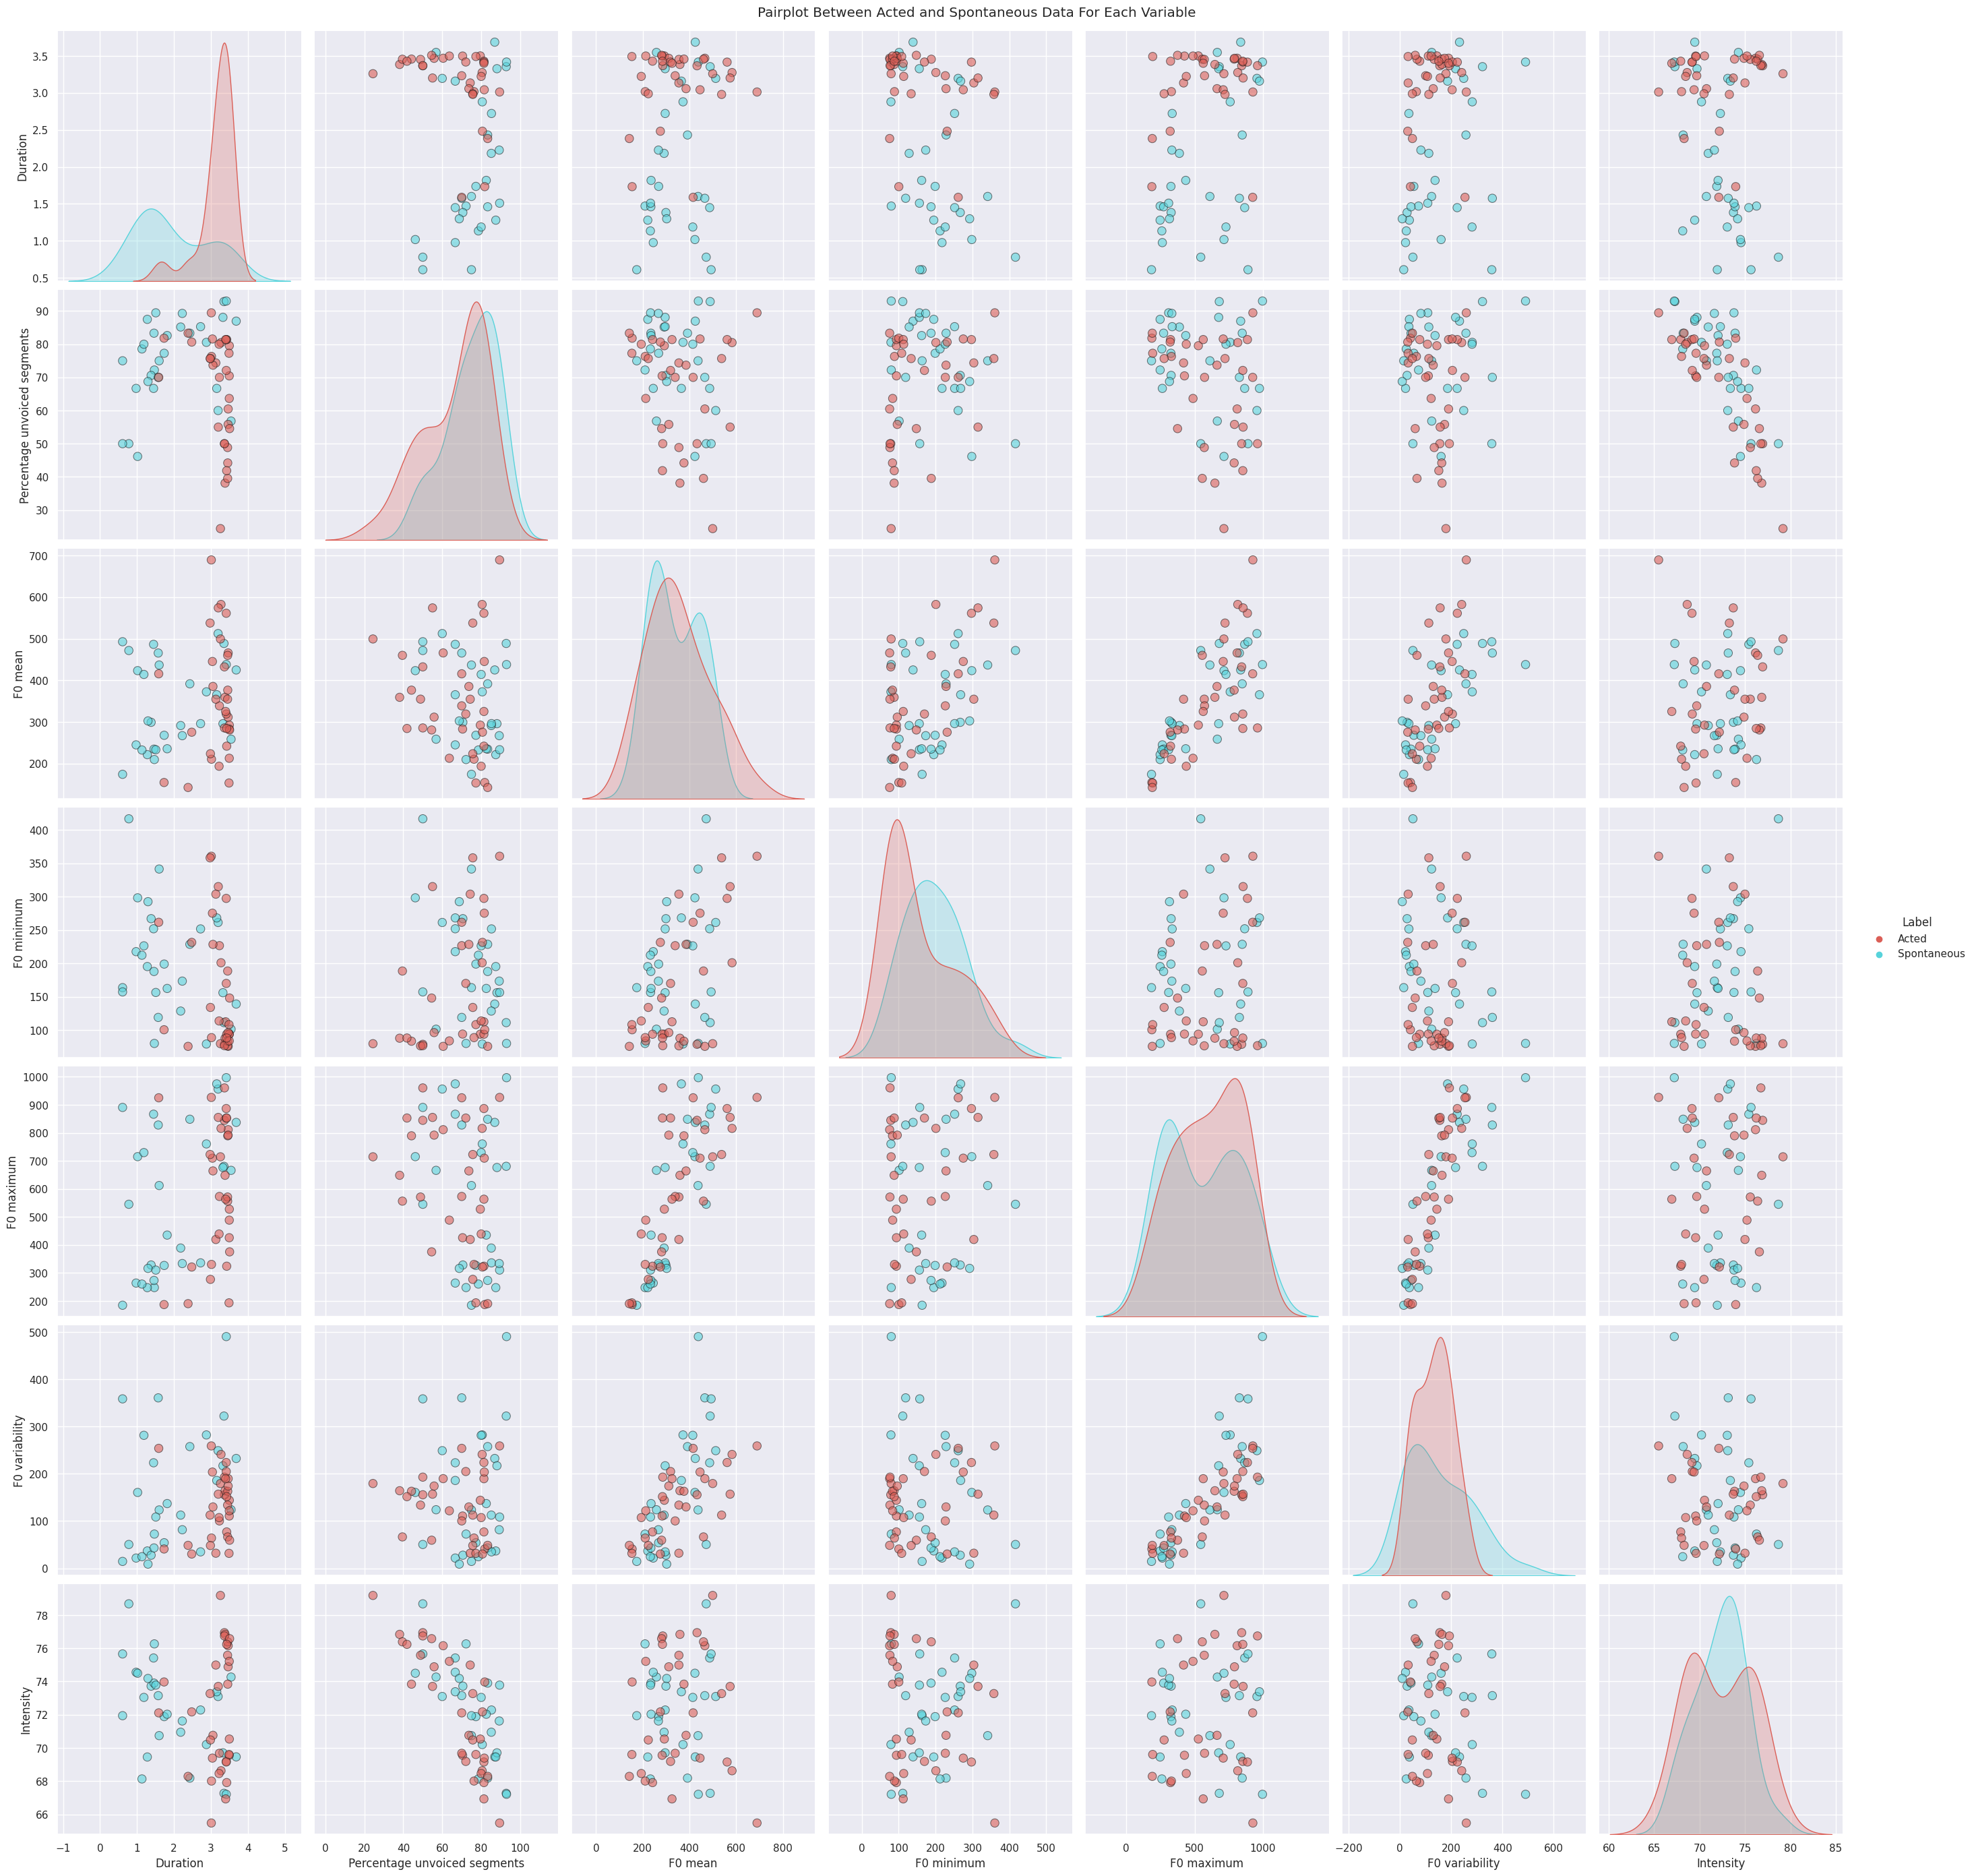

In [ ]:
#plot each parameter against each other for visual inspection
temp = data.copy()
temp["Label"] = np.where(temp["Label"] == 0, "Acted", "Spontaneous")
sns.pairplot(temp, hue="Label", hue_order=["Acted", "Spontaneous"], palette="hls", diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)
fig = plt.gcf()
fig.suptitle("Pairplot Between Acted and Spontaneous Data For Each Variable", y=1)
plt.show()

In [ ]:
#normalise the data using min-max normalisation
scaler = MinMaxScaler()
d = scaler.fit_transform(data)
scaled_data = pd.DataFrame(d, columns=data.columns)

In [ ]:
#inspect the statistics of the scaled data
scaled_data.describe()

,Duration,Percentage unvoiced segments,F0 mean,F0 minimum,F0 maximum,F0 variability,Intensity,Label
count,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000
mean,0.648215,0.673888,0.375717,0.297326,0.491523,0.282048,0.495835,0.468750
std,0.309151,0.225630,0.221348,0.259852,0.309288,0.206651,0.235198,0.502967
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.321019,0.524006,0.205953,0.053923,0.178743,0.102292,0.295860,0.000000
50%,0.793152,0.737433,0.328412,0.246819,0.502029,0.255302,0.492385,0.000000
75%,0.912418,0.831342,0.538661,0.471719,0.780865,0.405201,0.668441,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---
### Training the classifier
---




In [ ]:
#add the Filenames to the scaled data
filenames = filenames.reset_index(drop=True)
scaled_data["Filename"] = filenames

In [ ]:
#split the scaled data into data and true labels with the names of the files
X = scaled_data[scaled_data.columns.values[0:-2]]
y_inc_name = scaled_data[scaled_data.columns.values[-2:]]

In [ ]:
#split the scaled data into training and testing data
X_train, X_test, y_train_inc_name, y_test_inc_name = train_test_split(X, y_inc_name, random_state=1234, shuffle=True)

In [ ]:
#separate the Filename columns from the true labels
y_train = y_train_inc_name["Label"]
y_train_name = y_train_inc_name["Filename"]

y_test = y_test_inc_name["Label"]
y_test_name = y_test_inc_name["Filename"]

In [ ]:
#set a range of hyperparameters to finetune the classifier
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'sigmoid', 'rbf']}

#run the Support Vector Classifier using Grid Search Cross-Validation to determine the optimal hyperparameter settings
grid = GridSearchCV(SVC(random_state=1234, probability=True, decision_function_shape='ovr'), param_grid, refit = True, verbose = 3)

#fit the model for grid search
grid.fit(X_train, y_train)

#print the optimal classifier
print(grid.best_estimator_)

#predict class labels using the optimal classifier
grid_predictions_train = grid.predict(X_train)
grid_predictions_test = grid.predict(X_test)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.600 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.500 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.500 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.556 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.556 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.600 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.500 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.556 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.556 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.600 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf

---
### Evaluating the classifier
---

In [ ]:
def class_filegender_split(data_split, names) -> List[pd.core.frame.DataFrame]:
  '''This function takes the train or test split of the data as well as their
  respective filenames to determine a unique label representing the class and
  gender of the voice captured in the file. The data is then split based on
  these labels. In the end it returns these DataFrames in a list.'''

  #make a copy of the data to work with
  temp = data_split.copy()

  #add a column with predicted values to the copy
  temp["Predicted Value"] = grid.decision_function(temp)

  #create a list to store the unique class-file gender label of each file in
  c_fg_labs = []

  #determine the unique class-gile gender labels for each file based on the
  #filename and store them in the list
  for i in names.index:
    if bool(re.search("\_f\_", names[i].lower())):
      c_fg_labs.append(2)
    elif bool(re.search("\_m\_", names[i].lower())):
      c_fg_labs.append(3)
    elif bool(re.search("female", names[i].lower()) or re.search("girl", names[i].lower()) or re.search("woman", names[i].lower())):
      c_fg_labs.append(0)
    else:
      c_fg_labs.append(1)

  #add a column with labels to the copy
  temp["Class-File Gender Label"] = c_fg_labs

  #create a set of unique class-gender labels
  unique_vals = set(temp["Class-File Gender Label"].unique())

  #split the data into sections based on the unique class-gender labels
  c_fg_splits = [temp.loc[temp["Class-File Gender Label"] == val] for val in unique_vals]

  return c_fg_splits

In [ ]:
def split_evaluation(data_split, names) -> None:
  '''This function takes the train or test split of the data as well as their
  corresponding filenames to determine and print how much files of each class
  and gender where present in the data split. This way we can determine whether
  or not the split accurately represents the data.'''

  #load the class-file gender data splits into separate variables
  af, am, sf, sm = class_filegender_split(data_split, names)

  print(f"There are {len(af)} acted female files, {len(am)} acted male files, {len(sf)} spontaneous female files, and {len(sm)} spontaneous male files in this split of the data.")
  print(f"This totals to {len(af)+len(am)} acted files and {len(sf)+len(sm)} spontaneous files, and {len(af)+len(sf)} female files and {len(am)+len(sm)} male files.\n")

In [ ]:
def classification_metrics(true_labels, predicted_labels) -> None:
  '''This function takes the true labels and the predicted labels to print the
  corresponding classification report and confusion matrix. A reference table
  for the confusion matrix is printed as well.'''

  #print classification metrics
  print(classification_report(true_labels, predicted_labels))
  print(confusion_matrix(true_labels, predicted_labels))
  print()
  print("[[TP FP]\n [FN TN]]")

In [ ]:
def get_misclassified(true_labels, predicted_labels, names) -> List[str]:
  '''This function takes the true labels, the predicted labels, and the
  corresponding filenames to extract the names of the files that have been
  misclassified.
  '''
  #create a dataframe with the true labels, predicted labels, and file names
  eval_df = pd.DataFrame({'True Label':true_labels, 'Predicted Label':predicted_labels, 'Filename':names})

  #create a list to store the misclassified files in
  mc = []

  #loop through the data
  for i in eval_df.index:
    #extract the names of the files with mismatching predicted and true labels
    if eval_df.loc[i]["Predicted Label"] != eval_df.loc[i]["True Label"]:
      mc.append(eval_df.loc[i]["Filename"])

  return mc

In [ ]:
def evaluation(data_split, true_labels, predicted_labels, names) -> List[str]:
  '''This function takes the train or test split of the data, as well as their
  corresponding true labels, predicted labels, and filenames to create a
  complete oversight over the data split and classification performance. It also
  collects the names of the misclassified files for further inspection. In
  the end it returns this list of names for easy access.'''

  #create evaluation oversight
  split_evaluation(data_split, names)
  classification_metrics(true_labels, predicted_labels)

  #collect filenames of misclassified files
  mc = get_misclassified(true_labels, predicted_labels, names)

  return mc

In [ ]:
def plot_HoPwD(data_c_fg, colors, caption, legend_labs) -> None:
  '''This function takes the train or test data split with the unique class-file
  gender labels to plot a histogram of projections with a density estimation. To
  allow for some control, this function also takes an array of colors, a caption
  and an array of labels for the legend.'''

  #temporarily recombine the list of provided class-file gender splits to
  #determine the minimum and maximum predicted value for the range of the plot
  temp = pd.DataFrame()
  for data_split in data_c_fg:
    temp = pd.concat([temp, data_split])

  xmin = math.floor(min(temp["Predicted Value"]))
  xmax = math.ceil(max(temp["Predicted Value"]))

  #create a figure to plot the plots in
  fig, ax = plt.subplots()

  #plot the data per class-file gender label
  for index, c_fg in enumerate(data_c_fg):
    ax = sns.histplot(c_fg["Predicted Value"], color=colors[index], alpha=0.6, bins=np.arange(xmin, xmax+0.0001, 0.5), stat='count', kde=True)

  #plot the decision boundary and the standard confidence intervals of 1
  ax.vlines(0, color="black", ymin=0, ymax=1, transform = ax.get_xaxis_transform(), linewidth=1, linestyle="--", label="_0")
  ax.vlines(-1, color="black", ymin=0, ymax=1, transform = ax.get_xaxis_transform(), linewidth=1, linestyle=":", label="_1")
  ax.vlines(1, color="black", ymin=0, ymax=1, transform = ax.get_xaxis_transform(), linewidth=1, linestyle=":", label="_2")

  #add a title and a legend
  ax.set_title(f"Histogram of Projections with Density Plot\n{caption}")
  ax.legend(labels=legend_labs)

  #show plot
  plt.show()

In [ ]:
def plot_HoP_stacked_per_class(data_c_fg_act, data_c_fg_spt, colors, caption, legend_labs) -> None:
  '''This function takes the acted and spontaneous data of the train or test
  split with the unique class-file gender labels to plot a histogram of
  projections where the bins are stacked per class. To allow for some control,
  this function also takes an array of colors, a caption and an array of labels
  for the legend.'''

  #recombine the list of provided class-file gender splits per class to be able
  #to plot the inidividual classes in a stacked manner
  act = pd.concat([data_c_fg_act[0], data_c_fg_act[1]])
  spt = pd.concat([data_c_fg_spt[0], data_c_fg_spt[1]])

  #temporarily recombine the list of provided class-file gender splits to
  #determine the minimum and maximum predicted value for the range of the plot
  temp = pd.concat([act, spt])

  xmin = math.floor(min(temp["Predicted Value"]))
  xmax = math.ceil(max(temp["Predicted Value"]))

  #create a figure to plot the plots in
  fig, ax = plt.subplots()

  #plot the data per file gender stacked per class
  sns.histplot(data=act, x="Predicted Value", hue="Class-File Gender Label", multiple="stack", binwidth=0.5, binrange=[xmin, xmax], palette=colors[:2], alpha=0.5, ax=ax)
  sns.histplot(data=spt, x="Predicted Value", hue="Class-File Gender Label", multiple="stack", binwidth=0.5, binrange=[xmin, xmax], palette=colors[2:], alpha=0.5, ax=ax)

  #add a title and a legend
  ax.set_title(f"Histogram of Projections\n{caption}")
  ax.legend(labels=legend_labs)

  #plot the decision boundary and the standard confidence intervals of 1
  ax.vlines(0, color="black", ymin=0, ymax=1, transform = ax.get_xaxis_transform(), linewidth=1, linestyle="--", label="_0")
  ax.vlines(-1, color="black", ymin=0, ymax=1, transform = ax.get_xaxis_transform(), linewidth=1, linestyle=":", label="_1")
  ax.vlines(1, color="black", ymin=0, ymax=1, transform = ax.get_xaxis_transform(), linewidth=1, linestyle=":", label="_2")

  #show plot
  plt.show()

In [ ]:
def generate_plots(training, data_split, names) -> None:
  '''This function takes a boolean value whether the train split of the data is
  provided or not, as well as the corresponding split of the data with the
  unique class-file gender labels and their respective filenames. It uses this
  information to plot a range of plots for visual evaluation of the classifier
  performance..'''

  #set the part of the title to match the split of the data that is used
  if training:
    section = "Training"
  else:
    section = "Testing"

  #add class-file gender labels to the data
  c_fg = class_filegender_split(data_split, names)

  #separate the data into acted and spontaneous data
  c_fg_act = [c_fg[0], c_fg[1]]
  c_fg_spt = [c_fg[2], c_fg[3]]
  a_vs_s = [pd.concat([c_fg[0], c_fg[1]]), pd.concat([c_fg[2], c_fg[3]])]

  #plot the different configurations with density plot
  plot_HoPwD(data_c_fg=c_fg, colors=["red", "orange", "cyan", "blue"], caption=f"{section} Separation from Decision Boundary", legend_labs=["Acted Female", "Acted Male", "Spontaneous Female", "Spontaneous Male"])
  plot_HoPwD(data_c_fg=a_vs_s, colors=["red", "blue"], caption=f"{section} Separation from Decision Boundary\nActed vs. Spontaneous Data", legend_labs=["Acted", "Spontaneous"])
  plot_HoPwD(data_c_fg=c_fg_act, colors=["red", "orange"], caption=f"{section} Separation from Decision Boundary\nActed Data", legend_labs=["Acted Female", "Acted Male"])
  plot_HoPwD(data_c_fg=c_fg_spt, colors=["cyan", "blue"], caption=f"{section} Separation from Decision Boundary\nSpontaneous Data", legend_labs=["Spontaneous Female", "Spontaneous Male"])

  #plot without density plot
  plot_HoP_stacked_per_class(data_c_fg_act=c_fg_act, data_c_fg_spt=c_fg_spt, colors=["red", "orange", "cyan", "blue"], caption=f"{section} Separation from Decision Boundary\nActed vs. Spontaneous Data per Gender", legend_labs=["Acted male", "Acted female", "Spontaneous male", "Spontaneous female"])

In [ ]:
#run the numeric evaluation for the training data
mc_train = evaluation(X_train, y_train, grid_predictions_train, y_train_name)

There are 13 acted female files, 13 acted male files, 12 spontaneous female files, and 10 spontaneous male files in this split of the data.
This totals to 26 acted files and 22 spontaneous files, and 25 female files and 23 male files.

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90        26
         1.0       0.87      0.91      0.89        22

    accuracy                           0.90        48
   macro avg       0.89      0.90      0.90        48
weighted avg       0.90      0.90      0.90        48

[[23  3]
 [ 2 20]]

[[TP FP]
 [FN TN]]


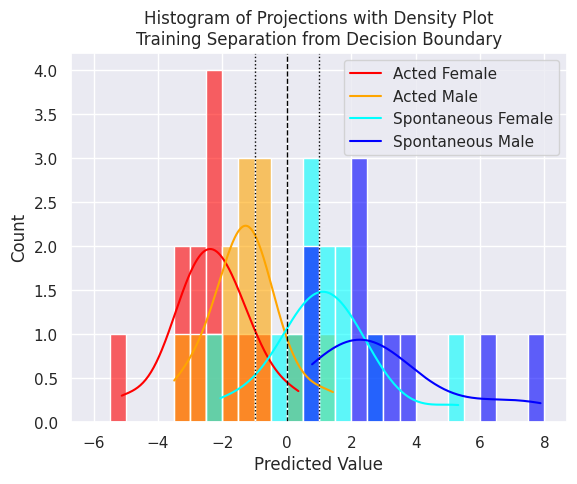

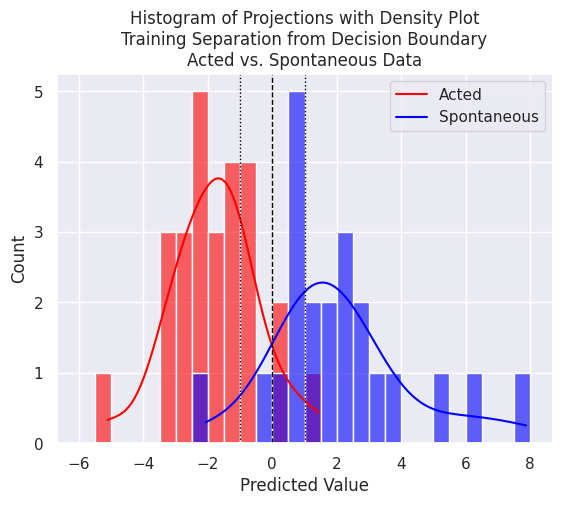

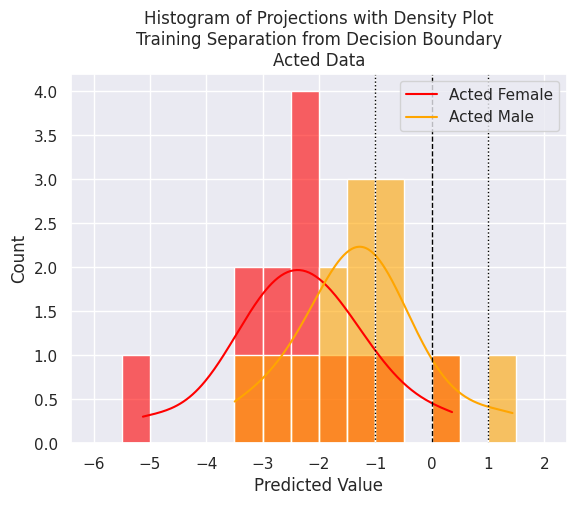

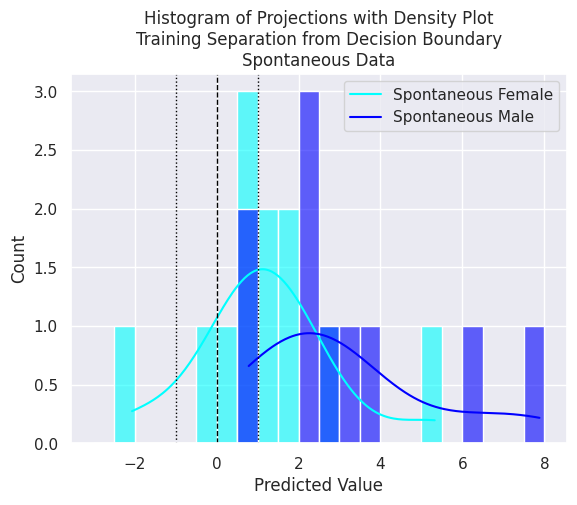

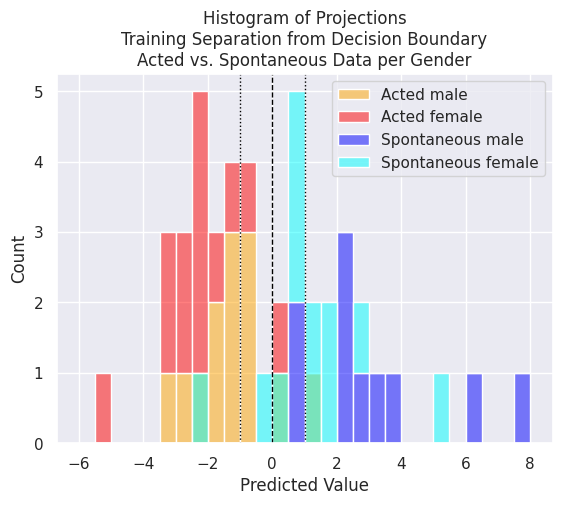

In [ ]:
#run the visual evaluation for the training data
generate_plots(True, X_train, y_train_name)

In [ ]:
#run the numeric evaluation for the testing data
mc_test = evaluation(X_test, y_test, grid_predictions_test, y_test_name)

There are 4 acted female files, 4 acted male files, 4 spontaneous female files, and 4 spontaneous male files in this split of the data.
This totals to 8 acted files and 8 spontaneous files, and 8 female files and 8 male files.

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88         8
         1.0       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16

[[7 1]
 [1 7]]

[[TP FP]
 [FN TN]]


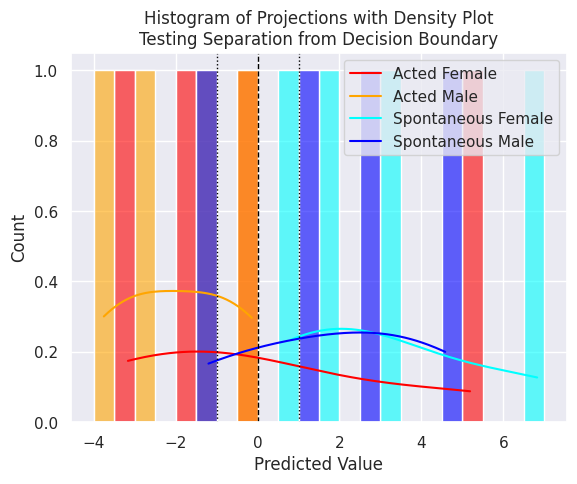

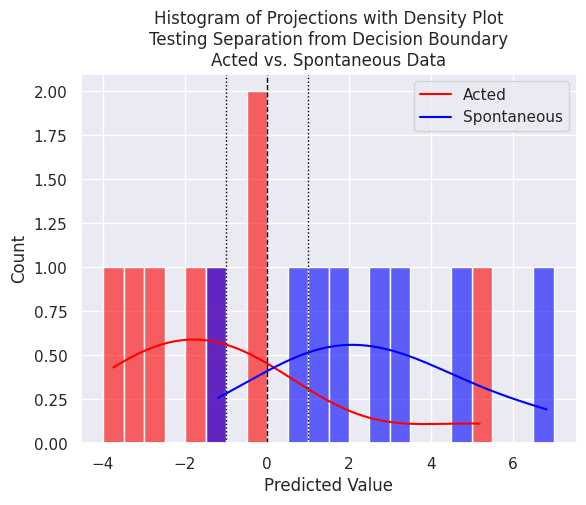

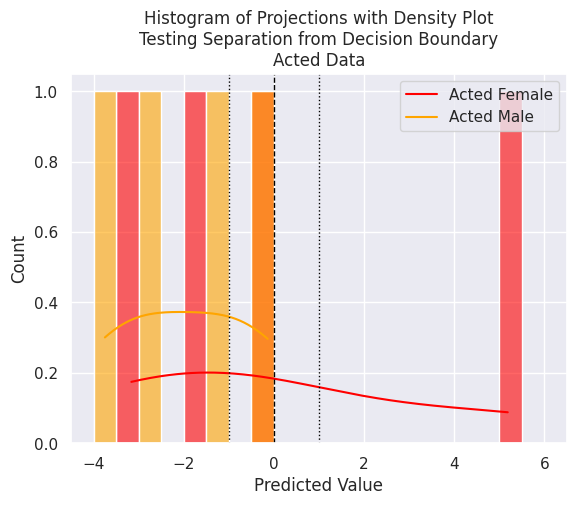

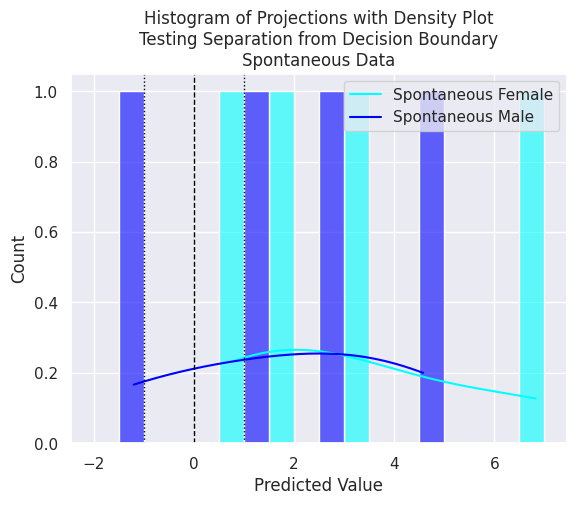

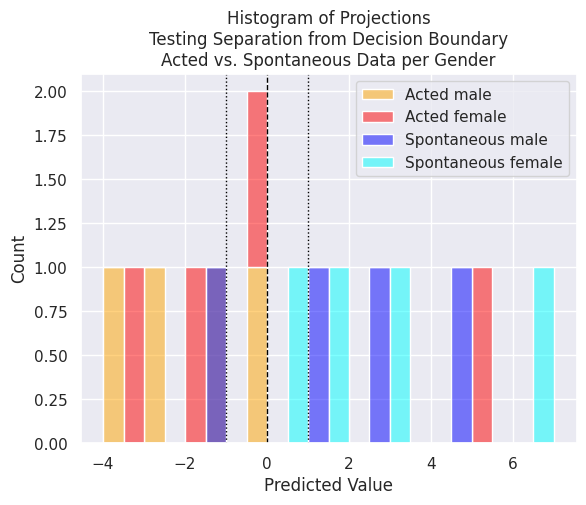

In [ ]:
#run the visual evaluation for the testing data
generate_plots(False, X_test, y_test_name)

---
### Factor analysis
---


In [ ]:
#Check if factor analysis can be performed on this dataset
chi_square_value, p_value = calculate_bartlett_sphericity(X)
chi_square_value, p_value

(321.53551600092374, 1.2890747278599587e-55)

With a p-value of practically zero it is reasonable to perform factor analysis.

In [ ]:
#instantiate the factor analysis object
fa = FactorAnalyzer(rotation='varimax')
fa.fit(X)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

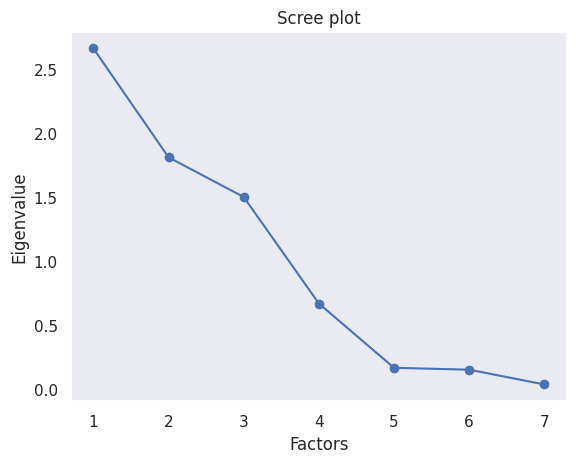

In [ ]:
#check Eigenvalues
ev, _ = fa.get_eigenvalues()
plt.scatter(range(1, X.shape[1]+1), ev)
plt.plot(range(1, X.shape[1]+1), ev)
plt.title("Scree plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

For the relevant number of factors we need to look at factors with an Eigenvalue larger than 1.

In [ ]:
#create a list to store the relevant factors in
factors = []

#collect the factors with an Eigenvalue larger than 1
for i in range(0, len(X.columns.values[np.where(ev>1)[0]])):
  factors.append(f"Factor {str(i+1)}")

#create an oversight of the contribution of each parameter to each of the relevant factors
pd.DataFrame(fa.loadings_, columns=factors, index=[X.columns])

,Factor 1,Factor 2,Factor 3
Duration,0.274062,0.020453,-0.413713
Percentage unvoiced segments,-0.152140,0.946545,0.106704
F0 mean,0.833731,-0.101971,0.290323
F0 minimum,0.197921,0.052949,0.986788
F0 maximum,0.982576,-0.151460,-0.098001
F0 variability,0.813476,0.152264,-0.224312
Intensity,-0.074778,-0.843017,0.073254


In [ ]:
#create an oversight of the variance accounted for by each of the relevant factors
pd.DataFrame(fa.get_factor_variance(), columns=factors, index=["SumSquare Loadings (Variance)","Proportional Variance","Cumulative Variance"])

,Factor 1,Factor 2,Factor 3
SumSquare Loadings (Variance),2.465326,1.666370,1.305868
Proportional Variance,0.352189,0.238053,0.186553
Cumulative Variance,0.352189,0.590242,0.776795


---
### Error analysis (visual)
---


In [ ]:
def get_class_means(data_split, names) -> tuple:
  '''This function takes a data split and their respective filenames. It uses
  this information to determine the acted and spontaneous class means, which it
  then returns as a tuple.'''

  #add class-file gender labels to the data
  c_fg = class_filegender_split(data_split, names)

  #separate the data into acted and spontaneous data
  a_vs_s = [pd.concat([c_fg[0], c_fg[1]]), pd.concat([c_fg[2], c_fg[3]])]

  #drop irrelevant values
  cfga = a_vs_s[0].drop(["Predicted Value", "Class-File Gender Label"], axis=1)
  cfgs = a_vs_s[1].drop(["Predicted Value", "Class-File Gender Label"], axis=1)

  #determine class means
  cma = cfga.mean()
  cms = cfgs.mean()

  return (cma, cms)

In [ ]:
def plot_param_dist_mc(mc, data_split, names, cm_train) -> None:
  '''This function takes the wrongly classified files from the train or test
  split of the data, as well as the corresponding split and their respective
  filenames. Additionally, it takes the acted and spontaneous class means from
  the training data. It uses this information to plot a parameter distribution
  of the misclassified files relative to the class means, which should be
  indicative of the decision boundary of the classifier.'''

  #add class-file gender labels to the data
  c_fg = class_filegender_split(data_split, names)

  #separate the data into acted and spontaneous data
  a_vs_s = [pd.concat([c_fg[0], c_fg[1]]), pd.concat([c_fg[2], c_fg[3]])]

  #loop over the misclassified files
  for fn in mc:
    ind = names.index[pd.Index(names).get_loc(fn)]
    #loop over the class-file gender splits
    for pos, c in enumerate(a_vs_s):
      #determine the variable order based on the class the file is located in
      if ind in c.index and pos == 0:
        temp = pd.concat([cm_train[0], cm_train[1], data_split.loc[ind]], axis=1)
        tl = "Acted"
      else:
        temp = pd.concat([cm_train[1], cm_train[0], data_split.loc[ind]], axis=1)
        tl = "Spontaneous"

      #set variable names
      temp.columns = ["Mean True Label","Mean Predicted Label","Datapoint"]

      #abbreviate parameter name
      temp = temp.rename(index={"Percentage unvoiced segments": "% Unvoiced segments"})

      #transform data to long format
      temp.reset_index(level=0, inplace=True)
      temp = pd.melt(temp, id_vars='index')

      #rename columns post transformation
      temp = temp.rename(columns={"index": "Parameter", "variable": "Variable", "value": "Value"})

      #plot the parameter values relative to the class means
      ax = sns.stripplot(data=temp, orient="h", jitter=False, x="Value", y="Parameter", hue="Variable", palette=["green", "red", "blue"], size=8, marker='D')

      #add a title and a legend
      ax.set_title(f"Parameter Distribution Relative to Training Class Means\n{fn} ({tl})")
      sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

      #show plot
      plt.show()
      break;

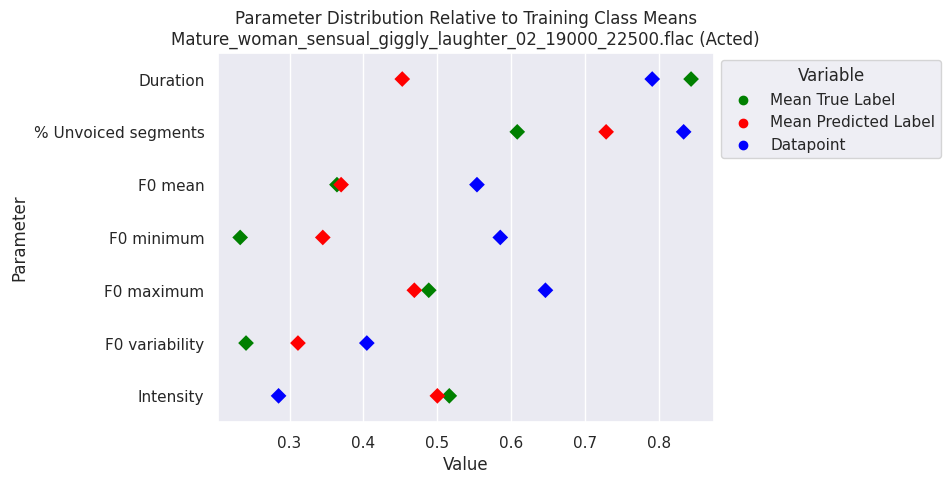

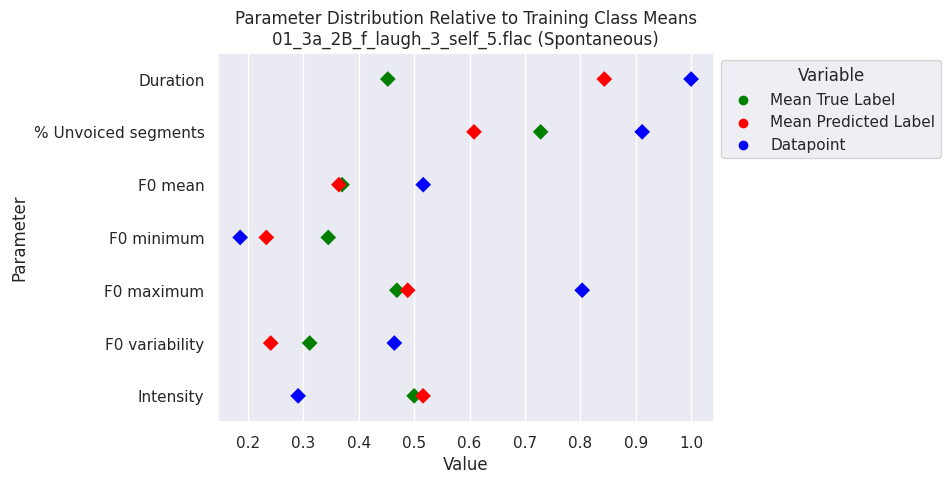

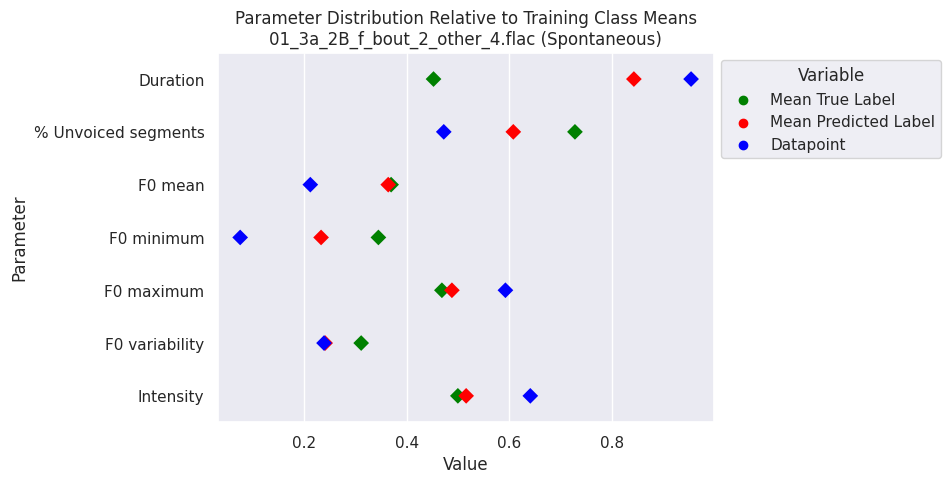

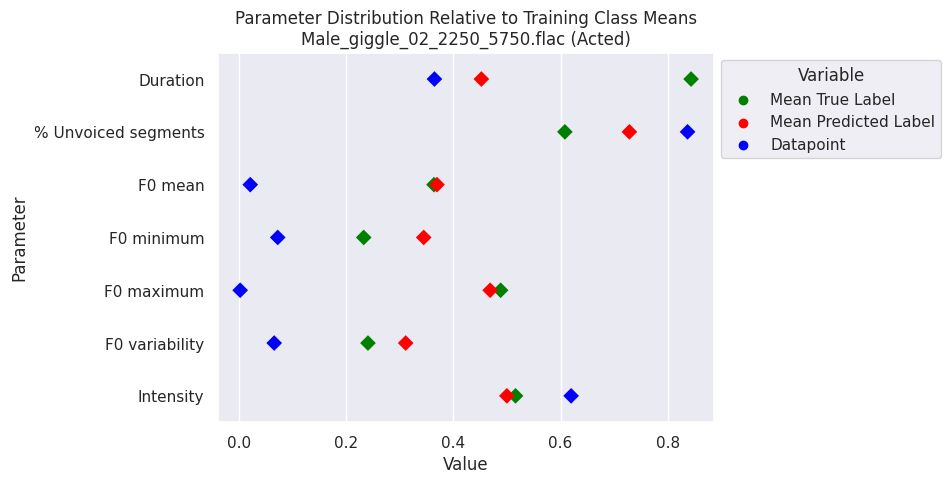

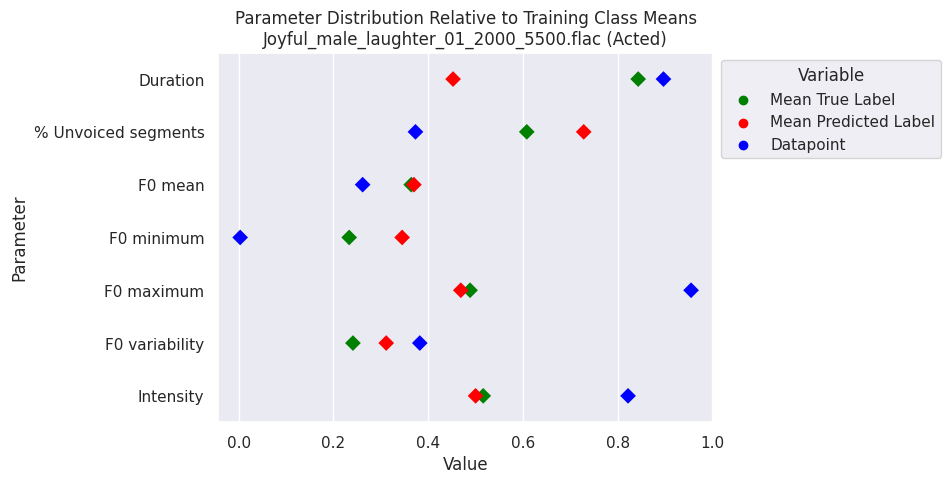

In [ ]:
#run the visual evaluation for the misclassified files of the training data
cm_train = get_class_means(X_train, y_train_name)
plot_param_dist_mc(mc_train, X_train, y_train_name, cm_train)

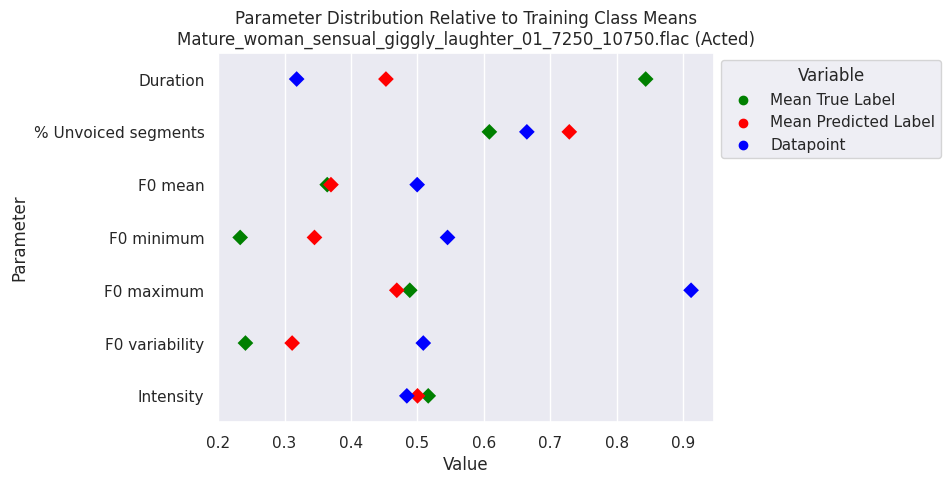

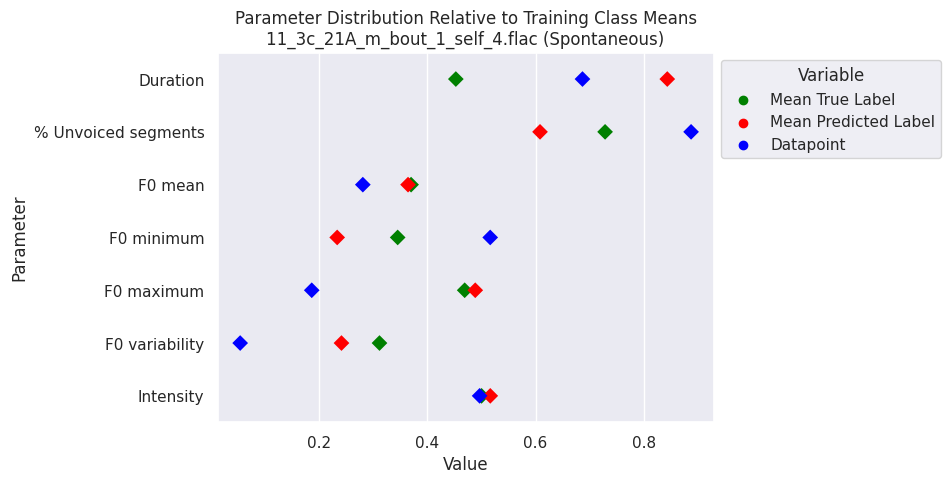

In [ ]:
#run the visual evaluation for the misclassified files of the testing data
cm_train = get_class_means(X_train, y_train_name)
plot_param_dist_mc(mc_test, X_test, y_test_name, cm_train)

---
### Sources
---

https://www.datacamp.com/tutorial/introduction-factor-analysis (Last accessed: 18 December, 2022)

https://towardsdatascience.com/a-practical-guide-to-interpreting-and-visualising-support-vector-machines-97d2a5b0564e (Last accessed: 18 December, 2022)